## **Super Dead Leaves**

Extension of the texture reproduction fidelity chart Dead Leaves using the _superformula_ to generate a variety of random shapes resembling leaves with multiple lobes.
The superformula parameters are randomly sampled in each lobe to generate an organic-looking shape. The final shape is rotated in a random orientation.
The superformula is a generalization of the superellipse that can generate a wide variety of geometric shapes:
- Johan Gielis. "A generic geometric transformation that unifies a wide range of natural and abstract shapes." American journal of botany 90, p. 333-338 (2003)

The superformula in polar coordinates is given by:

\begin{equation}
r(\theta) = \left( \left| \frac{\cos\left(\frac{m \theta}{4}\right)}{a} \right|^{n_2} + \left| \frac{\sin\left(\frac{m \theta}{4}\right)}{b} \right|^{n_3} \right)^{-\frac{1}{n_1}}
\end{equation}

where:
- \(r(\theta)\) defines the radial distance as a function of the polar angle \(\theta\).
- \(m\) determines the number of lobes (periodic symmetry).
- \(n_1\) adjusts the overall roundness or spikiness of the shape (smaller values yield more angular shapes).
- \(n_2\) and \(n_3\) influence the shape's curvature and the sharpness or smoothness of the lobes.
- \(a\) and \(b\) control the scaling along the \(x\) and \(y\) axes (fixed to 1).

The parameters \(n_1, n_2, n_3\) are randomly perturbed in each lobe to generate unique and varied shapes that resemble biological forms.

-------------

**Author**: Andreu Badal (Andreu.Badal-Soler (at) fda.hhs.gov)

**Date**: 2024/09/05

**Disclaimer**
This software and documentation (the "Software") were developed at the US Food and Drug Administration (FDA) by employees of the Federal Government in the course of their official duties. Pursuant to Title 17, Section 105 of the United States Code, this work is not subject to copyright protection and is in the public domain. Permission is hereby granted, free of charge, to any person obtaining a copy of the Software, to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, or sell copies of the Software or derivatives, and to permit persons to whom the Software is furnished to do so. FDA assumes no responsibility whatsoever for use by other parties of the Software, its source code, documentation or compiled executables, and makes no guarantees, expressed or implied, about its quality, reliability, or any other characteristic. Further, use of this code in no way implies endorsement by the FDA or confers any advantage in regulatory decisions. Although this software can be redistributed and/or modified freely, we ask that any derivative works bear some notice that they are derived from it, and any modified versions bear some notice that they have been modified.
       

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from time import time
import random

#%cd /home/abs/SuperDeadLeaves
#%ls -alrth
#%pwd

In [219]:
# Declare the Super Dead Leaves class and all the functions required to create random charts:

#GIF_frames = []  # !!GIF!! Declare space for the GIF frames (optional)

class SuperDeadLeaves:
    """
    Class to generate a random Super Dead Leaves chart based on the superformula shapes.
    
    The superformula [Johan Gielis, 2003] is an extension of the superellipse formula that generalizes the equation of a circle.
    It can represent a wide variety of complex shapes, including natural forms like flowers, shells, and more abstract geometric figures.
    
        \[
        r(\theta) = \left( \left| \frac{\cos\left(\frac{m \theta}{4}\right)}{a} \right|^n_2 + \left| \frac{\sin\left(\frac{m \theta}{4}\right)}{b} \right|^n_3 \right)^{-\frac{1}{n_1}}
        \]
    """
            
    def __init__(self, image_size=[512,512], seed=None, polygon_range=[3, 11], randomized=True, contrast=1.0, background_color=0.5, num_samples_chart=10000, rmin=0.0075, rmax=2/3, rr=500, sigma=3, borderFree=True):
        """
        Initialize the SuperDeadLeaves class and its superformula parameters.
        
        Parameters:
        - image_size (int, int): The dimensions of the image in x and y. Default: [512,512] pixels. A single integer can be input for a square image.
        - contrast (float): Controls the contrast of the shapes (0 to 1).
        - seed (int): random nunmber generator initialization seed (ie, image ID).
        - polygonVertices (int, int): minimum and maximum number of vertices in the sampled polygon. Eg: [3,3]=triangles, [3,4]=triangles and squares. 
        - randomized (bool): randomize the parameters of the superformula to get a variety of shapes
        - num_samples_chart (int): Number of shapes to be sampled. Should be large enough to cover the entire image.
        - rmin (float): Minimum radius for the objects (0 to 1).
        - rmax (float): Maximum radius for the objects (0 to 1).
        - rr (int): Radius distribution sampling rate. Higher values lead to a finer radius distribution.    
        - sigma (float): Controls the size distribution of the shapes. Higher values lead to more small shapes.
        - borderFree (bool): discard shapes touching the border of the image: the default background color will surround the generated patterns.
    
        """
        # ** Chart parameters:
        if isinstance(image_size, int):
            image_size = [image_size, image_size]
        self.image_size = image_size
        self.polygon_range = polygon_range
        self.contrast = np.clip(np.fabs(contrast), 0.0, 1.0)
        self.randomized = randomized
        self.background_color=background_color
        self.num_samples_chart=num_samples_chart
        self.rmin=rmin
        self.rmax=rmax
        self.rr=rr
        self.sigma=sigma
        self.borderFree=borderFree
        self.rng = np.random.default_rng(seed)  # Initialize a local random number generator with the input seed to be able to replicate the chart
            
        # ** Default superformula parameters (will be later changed if randomized is True):
        self.m = (polygon_range[0]+polygon_range[1])//2
        self.n1, self.n2, self.n3 = 3.0, 8.0, 4.0
        self.a , self.b = 1.0, 1.0
        
        self.num_points_polygon = 2*np.max(image_size)
        
        # Variability in the random sampling of the parameters in each lobe (0.5 -> randomly modify variable +- 50%)
        self.variability_n1 = 0.5  
        self.variability_n2 = 0.75
        self.variability_n3 = 0.75       


        
    def superformula(self, m: int, a: float, b: float, n1: float, n2: float, n3: float, theta: list):
        """
        Compute the radius r(θ) for the given list of angles θ using Johan Gielis' superformula with the input parameters.
        Reference: J. Gielis. "A generic geometric transformation that unifies a wide range of natural
                   and abstract shapes." American journal of botany 90, p. 333-338 (2003)
        """
        return (np.abs(np.cos(m*theta/4.0)/a)**n2 + np.abs(np.sin(m*theta/4.0)/b)**n3)**(-1.0/n1)

    
        
    def set_regular_polygon(self):
        """
        Define the superformula parameters that look approximtely like a regular polygon from Gielis paper:
        """
        if self.m < 3:
            self.m = 2     # Circle
            self.n1, self.n2, self.n3 = 2.0, 2.0, 2.0
        elif self.m == 3:   # Triangle
            self.n1, self.n2, self.n3 = 1000.0, 1980.0, 1980.0
        elif self.m == 4:   # Square
            self.n1, self.n2, self.n3 = 1.0, 1.0, 1.0
        elif self.m == 5:   # Pentagon
            self.n1, self.n2, self.n3 = 1000.0, 620.0, 620.0
        elif self.m == 6:   # Hexagon
            self.n1, self.n2, self.n3 = 1000.0, 390.0, 390.0
        elif self.m == 7:   # Heptagon
            self.n1, self.n2, self.n3 = 1000.0, 320.0, 320.0
        elif self.m == 8:   # Octagon
            self.n1, self.n2, self.n3 = 1000.0, 250.0, 250.0
        else:               # Starfish shape
            self.n1, self.n2, self.n3 = 9.0, 25.0, 25.0

        return self.n1, self.n2, self.n3
    

    
    def generate_polygon(self):
        """
        Generates a shape based on the Superformula, randomly perturbing the n1,n2,n3 parameters in each lobe if requested.
        Returns:
            Two lists with the X, Y coordinates of the polygon vertices
        """        
        # Generate polar coordinates theta values from 0 to 2*pi
        theta = np.linspace(0.0, 2.0*np.pi, self.num_points_polygon)
        r = np.zeros_like(theta)

        if self.randomized==False:
            nn1, nn2, nn3 = self.set_regular_polygon()
            
        # Iterate for each shape lobe:
        for i in range(self.m):
            start_angle = i * (2.0*np.pi/self.m)
            end_angle = (i + 1) * (2.0*np.pi/self.m)
            angle_range = (theta >= start_angle-1e-7) & (theta <= end_angle+1e-7)

            if self.randomized:
                nn2 = self.n2 + self.n2*(self.rng.uniform(-self.variability_n2, self.variability_n2))
                nn3 = self.n3 + self.n3*(self.rng.uniform(-self.variability_n3, self.variability_n3))
                nn1 = self.n1 + self.n1*(self.rng.uniform(-self.variability_n1, self.variability_n1))
                if np.fabs(nn1)<0.1:
                    nn1 = 0.1  # Avoid raising to large powers that give infinite r
                        
            # Calculate radius for the current list of lobe segment angles:
            r[angle_range] = self.superformula(self.m, self.a, self.b, nn1, nn2, nn3, theta[angle_range])
                   
        # Convert polar coordinates (r, theta) to Cartesian coordinates (x, y), with a random angular shift to randomize the shape orientation:
        theta0 = self.rng.uniform(0.0, 2.0*np.pi)
        X = r * np.cos(theta+theta0)
        Y = r * np.sin(theta+theta0)
        
        return X, Y 



    
    def generate_mask_from_polygon(self, X_vertex: float, Y_vertex: float, x_center: float=0.5, y_center: float=0.5, area_scale: float=0.1):
        """
        Generates a bitmap mask of the polygon stored in the class instance, previously generated by the "generate_polygon" function.
        All pixels inside the polygon are set to 0 (black) and all outside are set to 255 (white).
        The key feature of this function is the use of the pillow (PIL) library "polygon" function in a "Draw" object to fill the interior of the input polygonal shape.
        Args:
            x (float array): x coordinate of the polygon vertices.
            y (float array): y coordinate of the polygon vertices.
            x_center (float array): sampled center of the shape in the image, x coordinate.
            y_center (float array): sampled center of the shape in the image, y coordinate.
            area_scale (float): scaling factor of the polygon area
        Returns:
            numpy.ndarray (float): 2D numpy array with the polygon outline filled with color.
    """
        # Create a blank image
        mask = Image.new('L', self.image_size[::-1], color=0)    # !!DeBuG!! Do I need to reverse the image to be compatible with numpy for rectangular images??
    
        # Create a draw object
        draw = ImageDraw.Draw(mask)

        # Calculate the area of the polygon using the Shoelace formula (Trapezoid equation).
        area_polygon = 0.5 * abs(sum(X_vertex[i] * Y_vertex[i + 1] - Y_vertex[i] * X_vertex[i + 1] for i in range(-1, len(X_vertex) - 1)))
    
        # Scale the polygon units to the have the same area as if we had sampled a circle, move the origin to the sampled center, and transform to pixel coordinates by truncation:
        scaling_factor = np.sqrt(area_scale/area_polygon)
        nx = ((X_vertex*scaling_factor + x_center) * self.image_size[0]).astype(int)
        ny = ((Y_vertex*scaling_factor + y_center) * self.image_size[0]).astype(int)   # using image_size[0], not [1], to allow rectangular images with aspect ratio != 1 
    
        
        # Create a list of points for the polygon and fill with with white color (255)
        points = list(zip(nx, ny))
        draw.polygon(points, fill=255)    
        #     image.save(fileName)
    
        # Return the mask as a numpy array
        return np.array(mask)
        


    def generate_chart(self, filename: str=None):
        """
         Generate a Super Dead Leaves chart with randomized superformula shapes.
        
        The initial Dead Leaves algorithm was derived from Gabriel Peyré (2005) MATLAB code available at:
        https://github.com/gpeyre/matlab-toolboxes/blob/master/toolbox_image/compute_dead_leaves_image.m
        Mathematical reference: Yann Gousseau and Francois Roueff, "The dead leaves model: general results and 
        limits at small scales" (2003). Available at: https://arxiv.org/abs/math/0312035
    
        Returns:
        - numpy.ndarray (float32): The generated Super Dead Leaves image.
        """    
        # Initialize the image canvas with 'NaN' indicating uncovered areas
        img = np.full(self.image_size, np.nan).astype(np.float32)
    
        # Compute radius distribution using the input sampling rate 'rr'
        r_list = np.linspace(self.rmin, self.rmax, self.rr)
        r_dist = 1.0 / r_list**self.sigma
        if self.sigma > 0:
            r_dist -= 1.0 / self.rmax**self.sigma
        r_dist = np.cumsum(r_dist)
        r_dist = (r_dist - r_dist.min()) / (r_dist.max() - r_dist.min())
    
        # Total number of pixels to cover
        uncovered_pixels = self.image_size[0]*self.image_size[1]
    
        # Enable generating rectangular phantoms: 
        AspectRatio = self.image_size[1]/self.image_size[0];
        
        for ii in range(self.num_samples_chart):
            
            if ii>0 and ii%1000==0:
                print(f'...Sampled {ii} shapes of {self.num_samples_chart} ({100.0*ii/self.num_samples_chart}%)...')
            
            # Randomly sample a radius (but use the closest one in the pre-computed distribution)
            r = self.rng.random()
            I = np.argmin(np.fabs(r - r_dist))
            r = r_list[I]
    
            # Randomly choose a central position and albedo
            x = self.rng.random() * AspectRatio
            y = self.rng.random()
            a = 0.5 + (self.rng.random()-0.5)*self.contrast
    
            
            # Generate a new superformula-based shape (first as a polygon outline, then as a 2D bitmap with 0 outside the shape)
            
            # Sample the number of lobes in the next shape within the input interval
            self.m = self.rng.integers(low=self.polygon_range[0], high=self.polygon_range[1]+1)
        
            X_vertex, Y_vertex = self.generate_polygon()
            
            shape_mask = self.generate_mask_from_polygon(X_vertex, Y_vertex, x, y, np.pi*r**2)
    
            # Create a mask for the shape replacing pixels not yet covered (new shapes added "below" old ones, not covering them)
            mask = np.isnan(img) & (shape_mask!=0)
            # Old circular mask: mask = np.isnan(img) & ((X - x)**2 + (Y - y)**2 < r**2)
    
            if self.borderFree:
                # Reject any new shape that touches the outer edges of the image (ie, any true value in first/last row/column)
                if np.any(mask[0,:]) or np.any(mask[-1,:]) or np.any(mask[:,0]) or np.any(mask[:,-1]):
                    continue
    
            # Update the canvas with the new shape
            img[mask] = a
            uncovered_pixels -= np.sum(mask)

            #if (ii<250 and (ii&(ii-1))==0) or ii%250==0:     # !!GIF!! Iteration is a power of 2 or multiple of 500            
            #    print(f'...GIF frame {ii}...')
            #    GIF_frames.append((plt.cm.RdYlGn(img)*255).astype(np.uint8))  # Normalize and apply colormap   # !!GIF!!
            
            # Stop if the entire canvas is covered
            if uncovered_pixels == 0:
                break         
                
        # Replace any remaining 'NaN' values with background color:
        if uncovered_pixels>0:
            #print(f"Pixels not covered by any shape: {m} ({100.0*m/(image_size[0]*image_size[1]):.3}%). Background set to {background_color}.")
            img[np.isnan(img)] = self.background_color

        #GIF_frames.append((plt.cm.RdYlGn(img)*255).astype(np.uint8))   # !!GIF!! Save final image
        
        # Optionally, save the generated chart to an external file:
        if isinstance(filename, str):
            print(f" - Saving the chart image in file \"{filename}\".")
            image = Image.fromarray(img)
            image.save(filename)
        
        return img    




    def generate_cell_chart(self, cell_spacing_area_factor: float=1.0, cell_nucleus_area_factor: float=0.25, cell_nucleus_intensity: float=1.25, filename: str=None):   # !!CELL!!
        """
         Generate a chart based on the Super Dead Leaves chart with superformula shapes that resembles isolated cells on a microscope slide.
    
        Returns:
        - numpy.ndarray (float32): The generated Super Dead Leaves image.
        """
        # Initialize the image canvas with 'NaN' indicating uncovered areas
        img = np.full(self.image_size, np.nan).astype(np.float32)
        
        cell_boundary_mask = np.full(self.image_size, False).astype(bool)   # !!CELL!! Mask that is True for all pixels covered by a cell or in the desired empty space between cells.
    
        # Compute radius distribution using the input sampling rate 'rr'
        r_list = np.linspace(self.rmin, self.rmax, self.rr)
        r_dist = 1.0 / r_list**self.sigma
        if self.sigma > 0:
            r_dist -= 1.0 / self.rmax**self.sigma
        r_dist = np.cumsum(r_dist)
        r_dist = (r_dist - r_dist.min()) / (r_dist.max() - r_dist.min())
    
    
        # Enable generating rectangular phantoms: 
        AspectRatio = self.image_size[1]/self.image_size[0];
    
        ii = 0
        iteration = -1
        iteration_MAX = 10*self.num_samples_chart  # !!CELL!! Try sampling at most this amount of shapes before giving up (many shapes will be rejected due to overlapping).
        
        while ii<self.num_samples_chart and iteration<iteration_MAX:
            iteration = iteration + 1            
            if iteration>0 and iteration%100==0:
                print(f'...Sampled {iteration} shapes of {self.num_samples_chart} ({100.0*ii/self.num_samples_chart}%); {ii} added to chart...')
            
            # Randomly sample a radius (but use the closest one in the pre-computed distribution)
            r = self.rng.random()
            I = np.argmin(np.fabs(r - r_dist))
            r = r_list[I]
    
            # Randomly choose a central position and albedo
            x = self.rng.random() * AspectRatio
            y = self.rng.random()
            a = 0.5 + (self.rng.random()-0.5)*self.contrast
    
            
            # Generate a new superformula-based shape (first as a polygon outline, then as a 2D bitmap with 0 outside the shape)
            
            # Sample the number of lobes in the next shape within the input interval
            self.m = self.rng.integers(low=self.polygon_range[0], high=self.polygon_range[1]+1)

            X_vertex, Y_vertex = self.generate_polygon()

            shape_mask = self.generate_mask_from_polygon(X_vertex, Y_vertex, x, y, np.pi*r**2)

            reduced_shape_mask  = self.generate_mask_from_polygon(X_vertex, Y_vertex, x, y, (np.pi*r**2)*cell_nucleus_area_factor)  # !!CELL!! Mask for the interior nucleus
            expanded_shape_mask = self.generate_mask_from_polygon(X_vertex, Y_vertex, x, y, (np.pi*r**2)*cell_spacing_area_factor)  # !!CELL!! Mask for the cell and empty space around it
    
            if self.borderFree:
                # Reject any new shape that touches the outer edges of the image (ie, any true value in first/last row/column)
                if np.any(expanded_shape_mask[0,:]) or np.any(expanded_shape_mask[-1,:]) or np.any(expanded_shape_mask[:,0]) or np.any(expanded_shape_mask[:,-1]):
                    continue
                    
            if np.any(cell_boundary_mask & (expanded_shape_mask!=0)):
                continue   # !!CELL!! Reject the shape if any pixel in the expanded mask is already True in the cell boundary mask
            
            cell_boundary_mask = cell_boundary_mask | (expanded_shape_mask!=0)   # !!CELL!! Add new mask

            # Update the canvas with the new shape
            img[shape_mask!=0] = a            
            img[reduced_shape_mask!=0] = a * cell_nucleus_intensity
            
            #if (ii<25 and (ii&(ii-1))==0) or ii%25==0:     # !!GIF!! Iteration is a power of 2 or multiple of 500            
            #    print(f'...GIF frame {ii}...')
            #    GIF_frames.append((plt.cm.RdPu(img)*255).astype(np.uint8))  # Normalize and apply colormap   # !!GIF!!
            
            ii = ii + 1  # Count that a new shape was added to the chart

                
        # Replace any remaining 'NaN' values with background color:
        img[np.isnan(img)] = self.background_color

        #GIF_frames.append((plt.cm.RdPu(img)*255).astype(np.uint8))   # !!GIF!! Save final image
        
        # Optionally, save the generated chart to an external file:
        if isinstance(filename, str):
            print(f" - Saving the chart image in file \"{filename}\".")
            image = Image.fromarray(img)
            image.save(filename)
        
        print(f"\n  - Number of cells included in the chart: {ii}\n")
        
        return img

 ** Generating a Superformula shape with seed 82199125, m = 6:


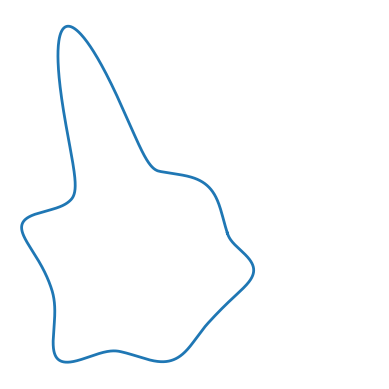

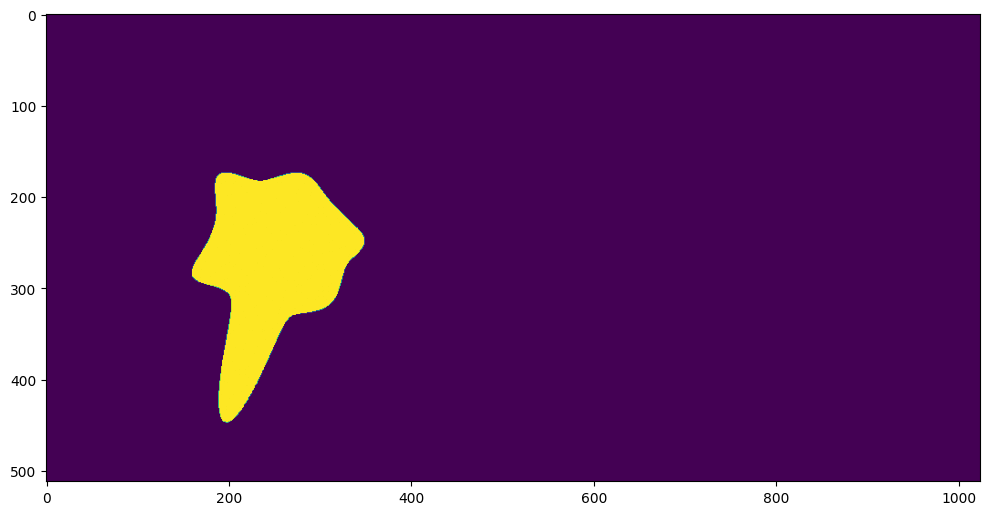

 ** Generating a "Super Dead Leaves" pattern chart:
    - Parameters: image_size = [512, 1024] pixels, seed=82199125, contrast=1.0, num_samples=10000, rmin=0.0075, rmax=0.6666666666666666, rr=500, sigma=3
                  polygon_range=[3, 10], randomized=True, borderFree=True
...Sampled 1000 shapes of 10000 (10.0%)...
...Sampled 2000 shapes of 10000 (20.0%)...
...Sampled 3000 shapes of 10000 (30.0%)...
...Sampled 4000 shapes of 10000 (40.0%)...
...Sampled 5000 shapes of 10000 (50.0%)...
...Sampled 6000 shapes of 10000 (60.0%)...
...Sampled 7000 shapes of 10000 (70.0%)...
...Sampled 8000 shapes of 10000 (80.0%)...
...Sampled 9000 shapes of 10000 (90.0%)...


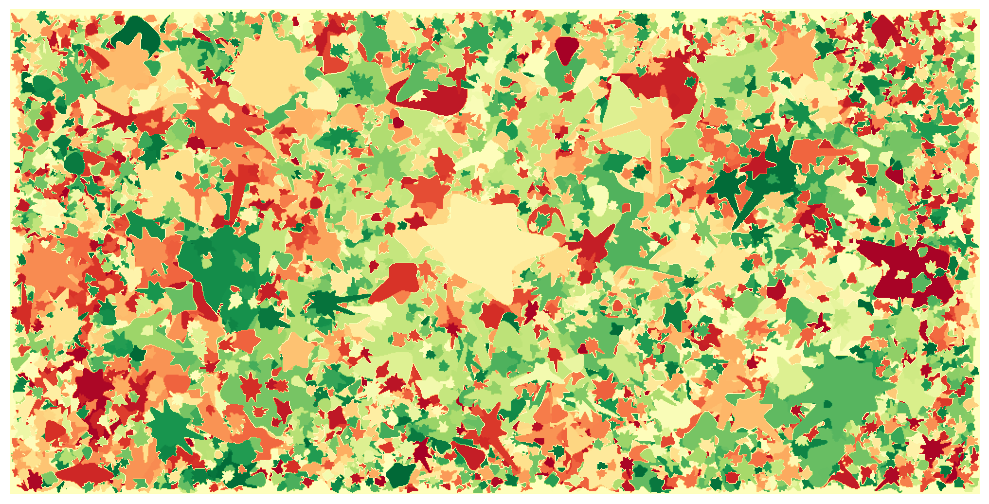

 - Time used to generate the image: 13.7 s
 ** Generating a traditional "Dead Leaves" pattern chart (seed=75121161):
...Sampled 1000 shapes of 10000 (10.0%)...
...Sampled 2000 shapes of 10000 (20.0%)...
...Sampled 3000 shapes of 10000 (30.0%)...
...Sampled 4000 shapes of 10000 (40.0%)...
...Sampled 5000 shapes of 10000 (50.0%)...
...Sampled 6000 shapes of 10000 (60.0%)...
...Sampled 7000 shapes of 10000 (70.0%)...
...Sampled 8000 shapes of 10000 (80.0%)...
...Sampled 9000 shapes of 10000 (90.0%)...


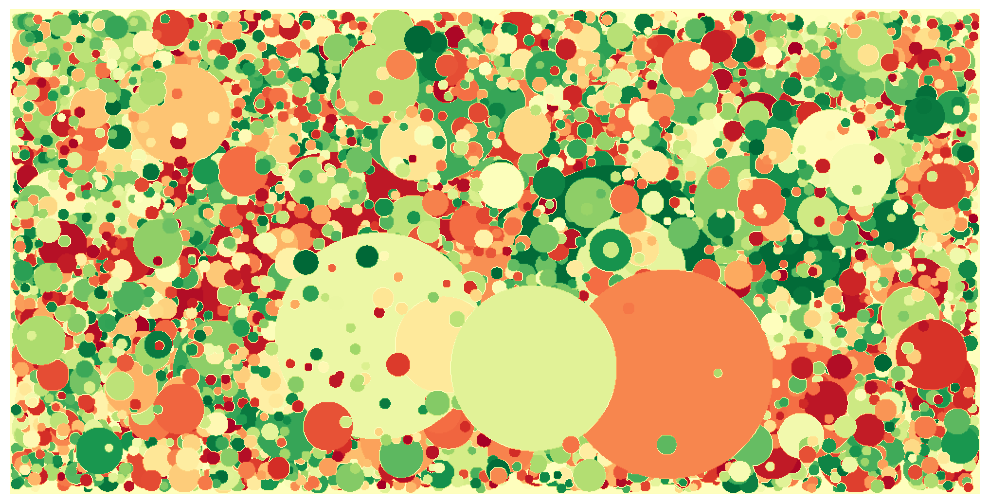

In [220]:
# Example generation of a Super Dead Leaves chart using superformula shapes:
if __name__ == "__main__":

    time0 = time()
    image_size = [512, 1024]  # [1080, 1920] #1024   # [1080, 1920]
    seed = np.random.randint(1, 1e8)

    # - Create a Super Dead Leaves class instance:
    SDL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=[3,10], randomized=True)

    # - Generate a sample shape:
    print(f" ** Generating a Superformula shape with seed {seed}, m = {SDL.m}:")
    X, Y = SDL.generate_polygon()    
    plt.plot(X, Y, linewidth=2)
    plt.axis('square')
    plt.axis('off')
    # plt.savefig('polygon.png')
    plt.show()    

    
    # - Generate a bitmap mask for the sample shape:
    shape_mask = SDL.generate_mask_from_polygon(X, Y)

    plt.figure(figsize=(10, 10))  #figsize=(4, 4), dpi=600)
    plt.imshow(shape_mask, vmin=0, vmax=256)
    #plt.axis('off')
    plt.tight_layout()
    plt.show()

    
    # - Generate a sample SDL chart:
    print(f" ** Generating a \"Super Dead Leaves\" pattern chart:")
    print(f"    - Parameters: image_size = {image_size} pixels, seed={seed}, contrast={SDL.contrast}, num_samples={SDL.num_samples_chart}, rmin={SDL.rmin}, rmax={SDL.rmax}, rr={SDL.rr}, sigma={SDL.sigma}")
    print(f"                  polygon_range={SDL.polygon_range}, randomized={SDL.randomized}, borderFree={SDL.borderFree}")

    chart = SDL.generate_chart()  # (f'SDL_{seed}.tif')
    
    plt.figure(figsize=(10, 10))  #figsize=(4, 4), dpi=600)
    plt.imshow(chart, cmap='RdYlGn', vmin=0, vmax=1)     #  my_cm    , cmap='gray', vmin=0, vmax=1)  'YlGn' 'RdYlGn'
    plt.axis('off')
    plt.tight_layout()
    plt.show()
  
    print(f" - Time used to generate the image: {(time()-time0):.3} s")


    # - Create a traditional Dead Leaves chart with circles:
    seed = np.random.randint(1, 1e8)
    print(f" ** Generating a traditional \"Dead Leaves\" pattern chart (seed={seed}):")
    DL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=[2,2], randomized=False)   # Generate only circles

    chart_DL = DL.generate_chart()  # (f'DL_{seed}.tif')
    
    plt.figure(figsize=(10, 10))  #figsize=(4, 4), dpi=600)
    plt.imshow(chart_DL, cmap='RdYlGn', vmin=0, vmax=1)     #  my_cm    , cmap='gray', vmin=0, vmax=1)  'YlGn' 'RdYlGn'
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    

In [221]:
# Create a GIF animation with chart generation frames:
# Uncomment all the lines above with the comment !!GIF!!
#import imageio
#fps = 3
#imageio.mimsave(f'cell_SDL_{seed}_animation.gif', GIF_frames, fps=fps)
#print(f'Creating GIF animation with {len(GIF_frames)} frames at {fps} fps.')

 ** Generating a cell pattern chart based on the "Super Dead Leaves" algorithm:
    - Parameters: image_size = [512, 1024] pixels, seed=9740721, contrast=1.0, num_samples=150, rmin=0.015, rmax=0.3, rr=500, sigma=3
                  polygon_range=[2, 6], randomized=True, borderFree=True
...Sampled 100 shapes of 150 (32.666666666666664%); 49 added to chart...
...Sampled 200 shapes of 150 (46.666666666666664%); 70 added to chart...
...Sampled 300 shapes of 150 (56.0%); 84 added to chart...
...Sampled 400 shapes of 150 (64.0%); 96 added to chart...
...Sampled 500 shapes of 150 (69.33333333333333%); 104 added to chart...
...Sampled 600 shapes of 150 (73.33333333333333%); 110 added to chart...
...Sampled 700 shapes of 150 (78.0%); 117 added to chart...
...Sampled 800 shapes of 150 (80.0%); 120 added to chart...
...Sampled 900 shapes of 150 (80.0%); 120 added to chart...
...Sampled 1000 shapes of 150 (83.33333333333333%); 125 added to chart...
...Sampled 1100 shapes of 150 (84.0%); 126 added 

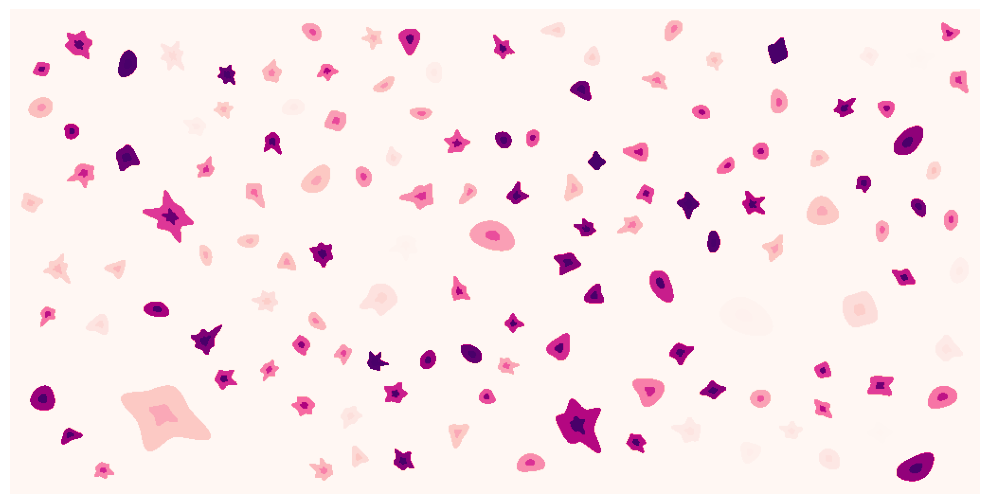

In [224]:
# Extension of SDL to generate a random cell chart:

#image_size = 1024   # [1080, 1920]
seed = np.random.randint(1, 1e8)  # 38717094

# - Create a Super Dead Leaves class instance:
SDL = SuperDeadLeaves(image_size=image_size, seed=seed, polygon_range=[2,6], randomized=True, borderFree=True)

# - Generate a sample cell SDL chart:

SDL.num_samples_chart = 150
#SDL.contrast = 0.5
SDL.rmin = 0.015
SDL.rmax = 0.300
SDL.variability_n1 = 0.2
SDL.background_color = 0.0

print(f" ** Generating a cell pattern chart based on the \"Super Dead Leaves\" algorithm:")
print(f"    - Parameters: image_size = {image_size} pixels, seed={seed}, contrast={SDL.contrast}, num_samples={SDL.num_samples_chart}, rmin={SDL.rmin}, rmax={SDL.rmax}, rr={SDL.rr}, sigma={SDL.sigma}")
print(f"                  polygon_range={SDL.polygon_range}, randomized={SDL.randomized}, borderFree={SDL.borderFree}")

fname = None #f'cell_SDL_{seed}.tif'  # None
cell_chart = SDL.generate_cell_chart(cell_spacing_area_factor=4.0, cell_nucleus_area_factor=0.10, cell_nucleus_intensity=1.5, filename=fname)  # !!CELL!!)  # (f'cellSDL_{seed}.tif')

plt.figure(figsize=(10, 10))  #figsize=(4, 4), dpi=600)
plt.imshow(cell_chart, cmap='RdPu', vmin=0, vmax=1)     #  RdPu    , cmap='gray', vmin=0, vmax=1)  'YlGn' 'RdYlGn'
plt.axis('off')
plt.tight_layout()
plt.show()      